In [1]:
# Install Dependencies

!pip install yfinance tensorflow scikit-learn matplotlib numpy pandas


In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import yfinance as yf


In [2]:
# Function to Download Stock Data

def download_stock_data(ticker, start="2015-01-01", end=None):
    data = yf.download(ticker, start=start, end=end)

    if "Adj Close" in data.columns:
        data = data[["Adj Close"]].rename(columns={"Adj Close": "price"})
    elif "Close" in data.columns:
        data = data[["Close"]].rename(columns={"Close": "price"})
    else:
        if ("Price","price") in data.columns:
            data = data[[("Price","price")]]
            data.columns = ["price"]
        else:
            raise ValueError("No suitable price column found.")

    data.dropna(inplace=True)
    return data


In [3]:
# Creating a function to build sequences

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [4]:
# Build and Train the LSTM Model

def train_lstm(series, window_size=60, train_ratio=0.8, epochs=20, batch_size=32):
    values = series.values.reshape(-1, 1)

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    n = len(scaled_values)
    train_size = int(n * train_ratio)

    train_data = scaled_values[:train_size]
    test_data = scaled_values[train_size - window_size:]  # overlap window

    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    # Reshape for LSTM [samples, timesteps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # LSTM Model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)

    return model, scaler, y_test_actual.flatten(), y_pred.flatten(), {"RMSE": rmse, "MAE": mae}


In [5]:
# Testing on AAPL

aapl = download_stock_data("AAPL")
model, scaler, y_test, y_pred, lstm_metrics = train_lstm(aapl["price"])
lstm_metrics


/tmp/ipython-input-3559366398.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0172
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7640e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0361e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7957e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9799e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0633e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8087e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5369e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6142e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3484e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1188e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6486e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3642e-04
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━

{'RMSE': np.float64(7.180326658836065), 'MAE': 5.514782770330256}

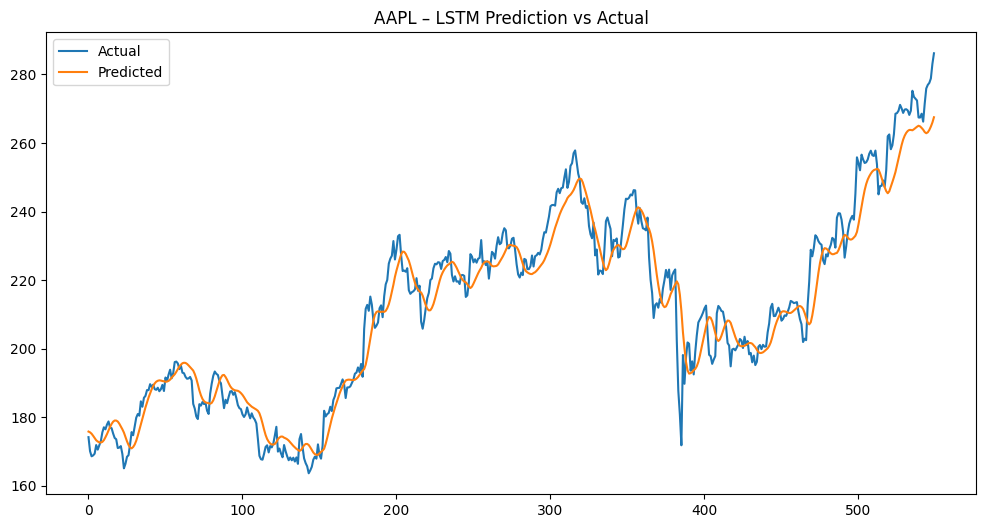

In [6]:
# Plot Actual vs Predicted

plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("AAPL – LSTM Prediction vs Actual")
plt.legend()
plt.show()
